In [1]:
import pandas as pd
import os
import re
import warnings
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import fisher_exact, ttest_1samp, norm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import dabest

from util.preprocessing import calc_overest_means, calc_detection_counts
from util.io import Layout
layout = Layout(data_dir = 'logs') 

In [2]:
# find subjects who are excluded for high detection rate
rm = []
for sub in layout.get_subjects():
    df = layout.load_clock_data(sub)
    counts = calc_detection_counts(df, catch = False)
    df = layout.load(sub, 'masked')
    df = df[~df.practice]
    tpr = df.aware[df.operant & (~df.catch)].mean()
    fpr = df.aware[(~df.operant) & (~df.catch)].mean()
    if (fisher_exact(counts)[1] < .05*2) & (tpr > fpr): # one-tailed test!
        rm.append(sub)
subs = [sub for sub in layout.get_subjects() if not sub in rm]
print('Excluded subjects for detections > false positive rate', rm)

# remove subjects that exceeded maximum sample size
extras = len(subs) - 80
print('and subjects', subs[-extras:], 'are extras.')
subs = subs[:-extras]

# how many in final list?
print(len(subs), 'are included in sample for main analyses.')

Excluded subjects for detections > false positive rate ['01', '07', '10', '13', '19', '24', '31', '32', '38', '43', '44', '50', '61', '66', '81', '82', '85', '95', '100']
and subjects ['99'] are extras.
80 are included in sample for main analyses.


In [3]:
dfs = [] # load data for all subjects (including excluded)
for sub in layout.get_subjects():
    masked = layout.load(sub, 'masked')
    unmasked = layout.load(sub, 'unmasked')
    df_sub = pd.concat([masked, unmasked])
    df_sub.insert(0, 'subject', sub)
    dfs.append(df_sub)
df = pd.concat(dfs)
df = df[(df.aware != True) | (~df.masked)] # rm trials where report seeing stim
df = df[~df.catch] # remove catch trials (where they definitely see stim)
df = df[~df.practice] # remove practice trials
df.overest_t *= 1e3 # convert to milliseconds
df.head()

,subject,trial,onset,masked,operant,practice,catch,contrast,stimulus_position,event_t,event_angle,resp_angle,overest_t,overest_angle,initial_offset_angle,aware
6,01,7,908.261245,True,True,False,False,0.415623,lower_left,6.975239,-1.693573,-1.581806,-45.537774,-0.111767,0.848077,False
7,01,8,927.828205,True,True,False,False,0.415623,lower_left,4.318238,-1.696029,-1.571270,-50.831523,-0.124759,-0.942891,False
8,01,9,944.845156,True,True,False,False,0.415623,lower_left,6.217584,-1.653762,-1.458682,-79.482746,-0.195080,-0.897114,False
9,01,10,964.012134,True,True,False,False,0.415623,lower_left,3.609372,-3.220117,-3.154225,-26.846915,-0.065892,1.041504,False
10,01,11,980.595645,True,True,False,False,0.415623,lower_left,4.195207,-0.087041,-6.192830,-72.277843,-0.177397,-0.865710,False


In [4]:
# test for regular intentional binding effect
data = df[~df.masked] 
mod = smf.mixedlm('overest_t ~ operant', data, groups = data['subject'])
mdf = mod.fit()
print(mdf.summary())

# compute one-tailed p-values for preregistered comparison
z = mdf.tvalues # really Z-values
p_unmasked = norm.sf(z['operant[T.True]'])
print('one-tailed p-value:', p_unmasked)

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  overest_t  
No. Observations:  8000     Method:              REML       
No. Groups:        100      Scale:               12028.1744 
Min. group size:   80       Log-Likelihood:      -49026.1073
Max. group size:   80       Converged:           Yes        
Mean group size:   80.0                                     
------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------
Intercept        -8.556    3.536 -2.420 0.016 -15.486 -1.625
operant[T.True]   5.257    2.452  2.144 0.032   0.450 10.063
Group Var       949.657    1.435                            

one-tailed p-value: 0.01603485907218986


In [5]:
# print confidence intervals out to more decimal places
mdf.conf_int(1 - .95)

,0,1
Intercept,-15.486428,-1.625384
operant[T.True],0.450197,10.063285
Group Var,0.053317,0.104589


In [6]:
warnings.filterwarnings('ignore') # suppress pandas warning
data = df[df.subject.isin(subs)] # only subjects that pass prerigstered exclusion!
data['aware'] = ~data.masked

# fixed linear model with random participant-level intercept
mod = smf.mixedlm('overest_t ~ operant*aware', data, groups = data['subject'])
mdf = mod.fit()
print(mdf.summary())

# compute one-tailed p-values for preregistered comparisons
z = mdf.tvalues # really Z-values
p_masked = norm.sf(z['operant[T.True]'])
p_interaction = norm.sf(z['operant[T.True]:aware[T.True]'])
print('one-tailed p-value for masked binding effect:', p_masked)
print('one-tailed p-value for interaction effect:', p_interaction)

                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       overest_t  
No. Observations:       12138         Method:                   REML       
No. Groups:             80            Scale:                    14821.1193 
Min. group size:        92            Log-Likelihood:           -75598.1578
Max. group size:        160           Converged:                Yes        
Mean group size:        151.7                                              
---------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------
Intercept                       -5.745    4.338 -1.324 0.185 -14.247  2.758
operant[T.True]                 -6.912    3.215 -2.150 0.032 -13.214 -0.610
aware[T.True]                   -1.538    3.140 -0.490 0.624  -7.692  4.616
operant[T.True]:aware[T.True]  

In [7]:
# print confidence intervals out to more decimal places
mdf.conf_int(1 - .95)

,0,1
Intercept,-14.247080,2.757549
operant[T.True],-13.213837,-0.609846
aware[T.True],-7.691756,4.616384
operant[T.True]:aware[T.True],1.979864,19.334904
Group Var,0.048232,0.098488


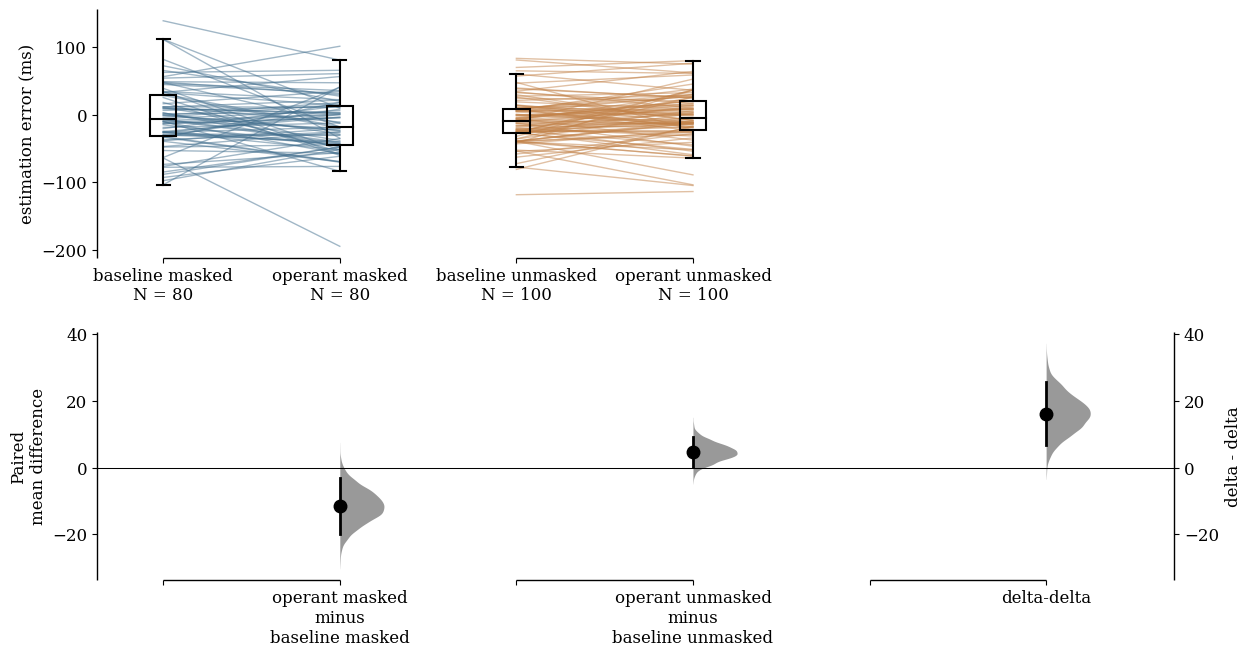

In [8]:
def load_means(layout):
    all_means = []
    for sub in layout.get_subjects(): 
        if sub in subs: 
            df = pd.concat([layout.load(sub, 'masked'), layout.load(sub, 'unmasked')])
        else:
            df = layout.load(sub, 'unmasked')
        df['aware'] = False # ignore aware reports
        means = calc_overest_means(df) # Huber means
        all_means.append(means)
    df = pd.DataFrame(all_means)
    return df

def tidy_dataframe(df, convert_to_ms = True):
    dfs = []
    for cond in df.columns:
        masked, operant = cond.split(' ')
        df_cond = df[[cond]].copy()
        df_cond.insert(0, column = 'subject', value = df_cond.index)
        df_cond.insert(0, column = 'operant', value = operant)
        df_cond.insert(0, column = 'masked', value = masked)
        df_cond.insert(0, column = 'condition', value = cond)
        df_cond.columns = [
            'condition', 'masked', 'type', 'subject', 'estimation error (ms)'
        ]
        dfs.append(df_cond)
    tidy_df = pd.concat(dfs, ignore_index = True)
    if convert_to_ms:
        tidy_df['estimation error (ms)'] *= 1000.
    return tidy_df

# load participant means in "tidy" (in the tidyverse sense) and untidy dataframes 
mean_df = load_means(layout)
tidy_df = tidy_dataframe(mean_df)
tidy_df = pd.concat([ # so dabest plots in correct order
    tidy_df[tidy_df.condition == 'masked baseline'],
    tidy_df[tidy_df.condition == 'masked operant'],
    tidy_df[tidy_df.condition == 'unmasked baseline'],
    tidy_df[tidy_df.condition == 'unmasked operant'],
]).reset_index()
data = dabest.load(
    data = tidy_df, 
    x = ['type', 'masked'], y = 'estimation error (ms)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'masked',
    delta2 = True,
    random_seed = 0,
    ci = 90 # corresponding to preregistered one-tail tests
)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize = (12, 3.5))
box_zorder = 10
props = dict(
    boxprops = {'facecolor': 'none', 'edgecolor': 'black', 'zorder': box_zorder},
    medianprops = {'color': 'black', 'zorder': box_zorder},
    whiskerprops = {'color': 'black', 'zorder': box_zorder},
    capprops = {'color': 'black', 'zorder': box_zorder}
)
sns.boxplot(
    data = tidy_df, 
    x = 'condition', y = 'estimation error (ms)', 
    order = ['masked baseline', 'masked operant', 'unmasked baseline', 'unmasked operant'],
    width = 0.15,
    showfliers = False,
    ax = ax,
    **props
)
data.mean_diff.plot(ax = ax)

ax.get_legend().remove()

plt.tight_layout()
if not os.path.exists('figures'):
    os.mkdir('figures')
f = os.path.join('figures', 'results.jpeg')
plt.savefig(f, dpi = 500, bbox_inches = 'tight')
plt.show()

In [9]:
data = dabest.load( 
    data = tidy_df, 
    x = ['type', 'masked'], y = 'estimation error (ms)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'masked',
    delta2 = True,
    random_seed = 0,
    ci = 95 # now compute intervals for reporting
)
data.cohens_d

DABEST v2023.2.14
                 
Good afternoon!
The current time is Wed Jul  9 16:42:07 2025.

The paired Cohen's d for repeated measures against baseline 
between baseline masked and operant masked is -0.249 [95%CI -0.461, -0.0261].
The p-value of the two-sided permutation t-test is 0.029, calculated for legacy purposes only. 

The paired Cohen's d for repeated measures against baseline 
between baseline unmasked and operant unmasked is 0.13 [95%CI -0.0156, 0.299].
The p-value of the two-sided permutation t-test is 0.0896, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [10]:
# preregistered manipulation check
unmasked = mean_df['unmasked operant'] - mean_df['unmasked baseline']
ttest_1samp(unmasked, popmean = 0, alternative = 'greater')

Ttest_1sampResult(statistic=1.693285241748269, pvalue=0.04677282141799269)